In [1]:
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

In [2]:

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "tum-adlr-ws21-04":
    os.chdir(basepath.parent.parent)
basepath = Path(os.getcwd())

from NerveNet.graph_util.mujoco_parser_settings import  RootRelationOption

In [3]:
parser_logs_dir = basepath / "logs_parser"
parser_logs_nervenet_dir = basepath / "logs_parser_nervenet"
nervenet_assets_dir = Path(os.getcwd()).parent / "NerveNet" / "environments" / "assets"
nervenet_submodul = basepath / "NerveNet" 
parser_logs_dir.exists(), parser_logs_dir, parser_logs_nervenet_dir.exists(), parser_logs_nervenet_dir

(True,
 WindowsPath('c:/Users/tsbau/git/tum-adlr-ws21-04/logs_parser'),
 True,
 WindowsPath('c:/Users/tsbau/git/tum-adlr-ws21-04/logs_parser_nervenet'))

In [4]:
parser_logs_files = [x.name for x in parser_logs_dir.glob('*.json') if x.is_file()]
parser_logs_nervenet_files = [x.name for x in parser_logs_nervenet_dir.glob('*.json') if x.is_file()]

In [5]:
# log files in both folder:
log_intersection = sorted(list(set(parser_logs_files) & set(parser_logs_nervenet_files)))
groups = ["Walker", "WalkersFullcheetah", "WalkersHalf", "Centipede", "Hopper", "Ant"]
grouped_logs = {
            group_name: [file_name
                         for file_name in log_intersection if group_name in file_name]
            for group_name in groups
        }

In [11]:
#some settings
edge_colors = {
    10:"blue", # root-body
    3:"green", # body-body
    6:"blue", # joint-body
}

def visualize_task_graph_comparison(task_name:str,
                                    figsize=(20, 10),
                                    use_sibling_relations: bool = True,
                                    root_relation_option: RootRelationOption = RootRelationOption.BODY):
    assert f"{task_name}.json" in log_intersection, f"Task with name {task_name} not available for comparison"
    seed = random.getrandbits(32)
    fig = plt.figure(figsize=figsize)
    fig.add_subplot(1,2, 1)
    task_log = plot_task_graph(task_name = task_name, 
                   #log_dir = parser_logs_dir,
                   seed = seed,
                   use_sibling_relations=use_sibling_relations,
                   root_relation_option=root_relation_option)
    fig.add_subplot(1,2, 2)
    task_log_nervenet = plot_task_graph(task_name = task_name, 
                   #log_dir = parser_logs_nervenet_dir,
                    use_nervenet_parser=True,
                   seed = seed,
                   use_sibling_relations=use_sibling_relations,
                   root_relation_option=root_relation_option)
    fig.tight_layout()
    plt.show()
    return task_log, task_log_nervenet

def plot_task_graph(task_name:str, log_dir:Path=None, seed:int=None, use_nervenet_parser=False,
                                    use_sibling_relations: bool = True,
                                    root_relation_option: RootRelationOption = None):
    if log_dir is not None:
        with open(str(log_dir / f"{task_name}.json")) as json_file:
            task_log = json.load(json_file)
    else:
        os.chdir(nervenet_submodul)
        if use_nervenet_parser:
            from NerveNet.graph_util.mujoco_parser_nervenet import parse_mujoco_graph
            root_connection_option = "yN, " if use_sibling_relations else "nN, "
            root_connection_option += "Rb, " if root_relation_option ==  RootRelationOption.BODY else ""
            root_connection_option += "Ra, " if root_relation_option ==  RootRelationOption.ALL else ""
            root_connection_option += "Rn, " if root_relation_option ==  RootRelationOption.NONE else ""
            root_connection_option += "sE"
            
            task_log = parse_mujoco_graph(task_name=task_name,
                                          xml_assets_path=nervenet_assets_dir,
                                          root_connection_option=root_connection_option)
        else:
            from NerveNet.graph_util.mujoco_parser import parse_mujoco_graph
            task_log = parse_mujoco_graph(task_name=task_name, xml_assets_path=nervenet_assets_dir,
                   use_sibling_relations=use_sibling_relations,
                   root_relation_option=root_relation_option)
        
    
    node_colors = {
        "red": task_log["node_type_dict"]["root"],
        "blue": task_log["node_type_dict"]["joint"],
        "black": task_log["node_type_dict"]["body"],
    }

    node_names = {node["id"]: node["raw_name"] for node in task_log["tree"] if "raw_name" in node.keys()}
    node_names[0] = "root"
    
    # Generate graph structure
    G = nx.Graph()
    for i in range(task_log["num_nodes"]):
        G.add_node(i)
        for j in range(i, task_log["num_nodes"]):
            if task_log["relation_matrix"][i][j] != 0:
                G.add_edge(i, j)
    
    pos = nx.spring_layout(G, seed=seed)#, pos={0: np.array([ 0, 0])})

    options = {"node_size": 100, "alpha": 0.8}
    for color, nodes in node_colors.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, **options)
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, **options)


    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    for p in pos:  # raise text positions
        pos[p][1] += 0.055
    nx.draw_networkx_labels(G, pos, node_names, font_size=12)
    
    return task_log

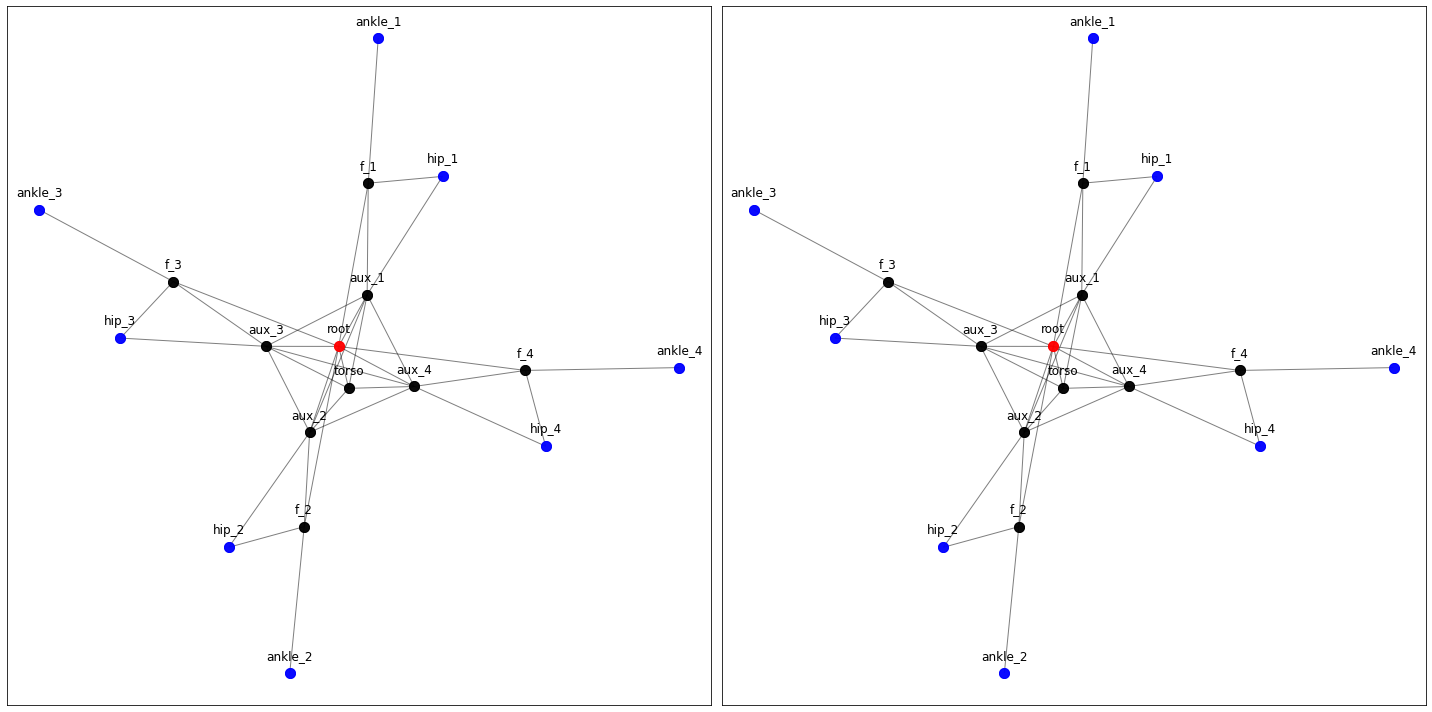

In [12]:
ant_log = visualize_task_graph_comparison("AntS-v1",
                                          use_sibling_relations = True,
                                          root_relation_option = RootRelationOption.BODY)

In [13]:
#ant_bullet_log = visualize_task_graph_comparison("AntBulletEnv-v0")

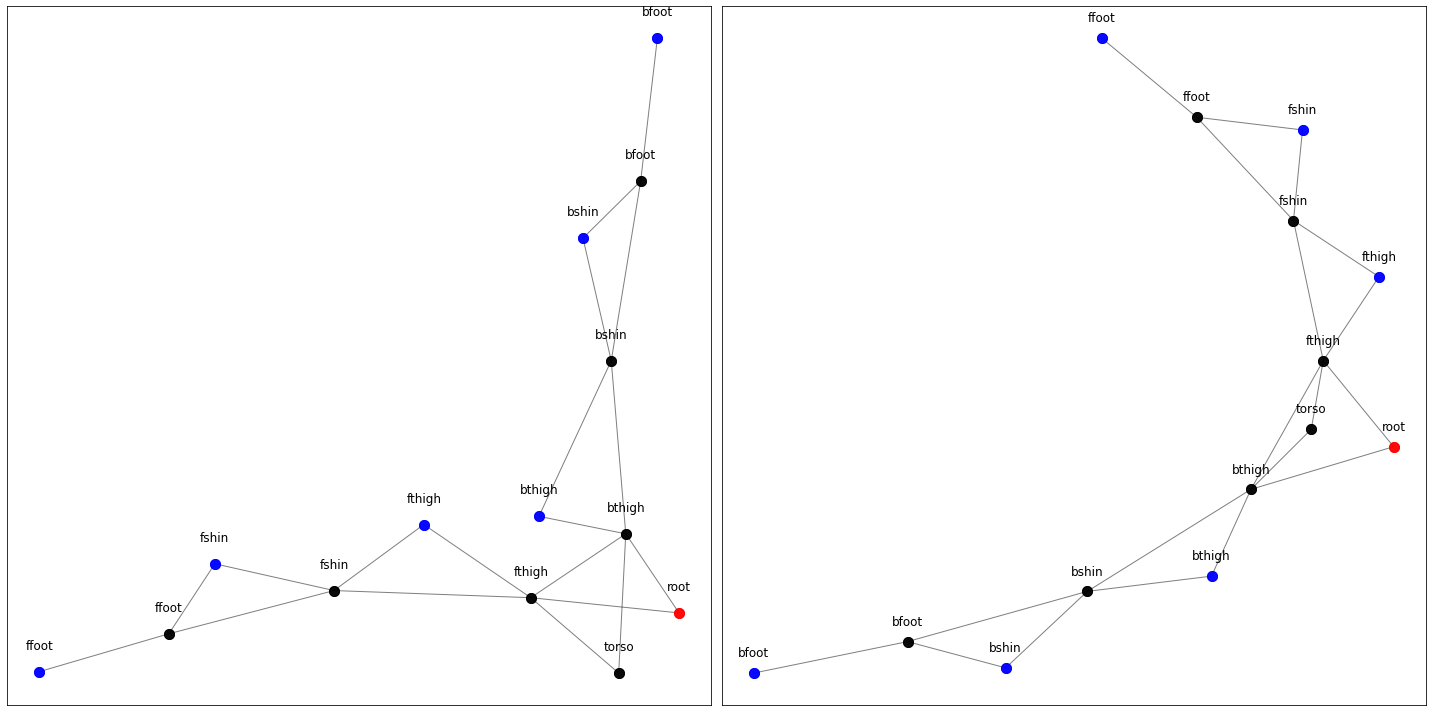

In [14]:
HalfCheetah_log = visualize_task_graph_comparison("HalfCheetah-v1",
                                          use_sibling_relations = True,
                                          root_relation_option = RootRelationOption.NONE)

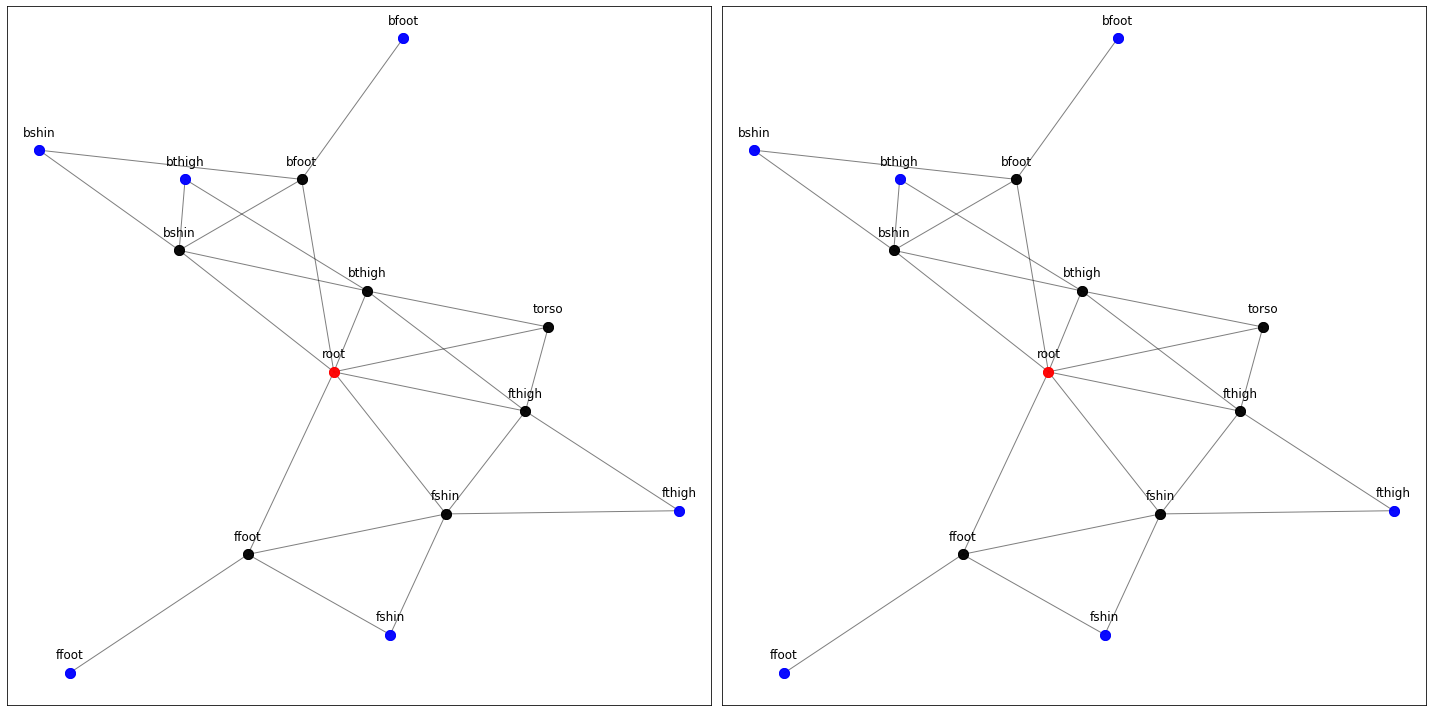

In [10]:
HalfCheetah_log = visualize_task_graph_comparison("HalfCheetah-v1",
                                          use_sibling_relations = True,
                                          root_relation_option = RootRelationOption.BODY)

AssertionError: Every node must be assigned to exactly one group!

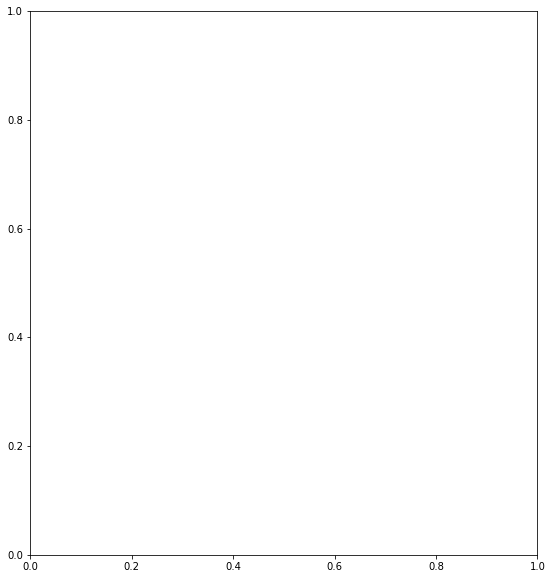

In [11]:
CentipedeFour_log = visualize_task_graph_comparison("CentipedeFour-v1",
                                          use_sibling_relations = True,
                                          root_relation_option = RootRelationOption.BODY)

In [ ]:
CentipedeFour_log = visualize_task_graph_comparison("CentipedeEight-v1", figsize=(30,15),
                                          use_sibling_relations = True,
                                          root_relation_option = RootRelationOption.BODY)

In [ ]:
Humanoid_log = visualize_task_graph_comparison("Humanoid-v1",
                                          use_sibling_relations = True,
                                          root_relation_option = RootRelationOption.BODY)

In [ ]:
WalkersKangaroo_log = visualize_task_graph_comparison("WalkersKangaroo-v1",
                                          use_sibling_relations = True,
                                          root_relation_option = RootRelationOption.BODY)

In [ ]:
WalkersOstrich_log = visualize_task_graph_comparison("WalkersOstrich-v1",
                                          use_sibling_relations = True,
                                          root_relation_option = RootRelationOption.BODY)

In [ ]:
#ant_log[0]["tree"]

In [ ]:
ant_log[0]["node_type_dict"]

In [15]:
ant_log[0]["obs_input_mapping"]

{0: [0, 1, 2, 3, 4, 5, 6, 7],
 3: [8, 9],
 5: [9, 10],
 7: [10, 11],
 9: [11, 12],
 11: [12, 13],
 13: [13, 14],
 15: [14, 15],
 17: [15, 16],
 1: [],
 2: [],
 4: [],
 6: [],
 8: [],
 10: [],
 12: [],
 14: [],
 16: []}

In [ ]:
ant_log[0]["num_nodes"]

In [ ]:
ant_log[0]["relation_matrix"]

In [8]:
ant_log[0].keys()

dict_keys(['tree', 'relation_matrix', 'node_type_dict', 'output_type_dict', 'output_list', 'obs_input_mapping', 'static_input_mapping', 'input_type_dict', 'num_nodes'])

In [ ]:
ant_log[0]["output_type_dict"]

In [ ]:
ant_log[0]["output_list"]

In [ ]:
ant_log[1]["node_parameters"]

In [ ]:
ant_log[1]["para_size_dict"]

In [ ]:
ant_log[0]["debug_info"]

In [ ]:
[node for node in ant_log[0]["tree"] if node["id"] in ant_log[0]["output_list"]]

In [ ]:
names = ["t", "a", "c"]

In [ ]:
default_dict = {"c":4}
update_dict = {"t":1, "z": 2, "a":3}
test_dict = default_dict.copy()
default_dict, update_dict

In [ ]:
test_dict.update(update_dict)
test_dict

In [ ]:
{key:test_dict[key] for key in names}

In [ ]:
test_dict.pop("t")

In [ ]:
test_dict